In [ ]:
!pip install rdkit optuna xgboost pyswarm

In [3]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from pyswarm import pso
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from datetime import datetime
from joblib import parallel_backend
import optuna
from optuna.pruners import SuccessiveHalvingPruner
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import joblib
from joblib import dump, load
from rdkit.Chem import AllChem
import warnings
    # = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
    #optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

os.chdir("/home/jovyan/ML_Project")

In [4]:
def read_input_data(filename):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(filename, encoding='ISO-8859-1')
    
    # Define the required columns for the analysis
    required_columns = ['SMILES', 'TempC', 'Sigma']
    
    # Check if all required columns are present in the DataFrame
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Input file must contain columns: {', '.join(required_columns)}")
    
    # Convert temperature to Kelvin and ensure it's numeric
    df['TempC'] = pd.to_numeric(df['TempC'], errors='coerce')# + 273
    
    # Ensure Sigma (surface tension) is numeric
    df['Sigma'] = pd.to_numeric(df['Sigma'], errors='coerce')
    
    # Remove rows with missing values in required columns
    return df.dropna(subset=required_columns)

def calculate_molecular_properties(smiles):
  try:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
      raise ValueError(f"Invalid SMILES: {smiles}")

    molar_weight = Descriptors.MolWt(mol)
    num_carbon = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
    num_oxygen = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O')
    num_hydrogen = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'H')
    num_nitrogen = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N')
    num_sulfur = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'S')
    num_phosphorus = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'P')
    num_unsaturated_bonds = 0.0
    num_chlorine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cl')
    num_fluorine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'F')
    num_iodine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'I')
    num_bromine = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Br')

    oc_ratio = num_oxygen / num_carbon if num_carbon else 0
    hc_ratio = num_hydrogen / num_carbon if num_carbon else 0
    nc_ratio = num_nitrogen / num_carbon if num_carbon else 0
    sc_ratio = num_sulfur / num_carbon if num_carbon else 0
    pc_ratio = num_phosphorus / num_carbon if num_carbon else 0
    cl_c_ratio = num_chlorine / num_carbon if num_carbon else 0
    f_c_ratio = num_fluorine / num_carbon if num_carbon else 0
    i_c_ratio = num_iodine / num_carbon if num_carbon else 0
    br_c_ratio = num_bromine / num_carbon if num_carbon else 0
    degree_of_saturation = (2 * num_carbon + 2 + num_nitrogen - num_hydrogen) / 2

    return [molar_weight, oc_ratio, hc_ratio, nc_ratio, sc_ratio, pc_ratio, degree_of_saturation,
            cl_c_ratio, f_c_ratio, i_c_ratio, br_c_ratio]
  except Exception as e:
    print(f"Error processing SMILES '{smiles}': {e}")
    return [np.nan] * 11

# Function to convert SMILES codes to MACCS keys
def smiles_to_maccs(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        maccs = MACCSkeys.GenMACCSKeys(mol)
        return np.array(maccs)
    except:
        return None

# Function to convert SMILES codes to Morgan fingerprints
def smiles_to_morgan(smiles, radius=2, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return np.array(morgan)
    except:
        return None

In [9]:
def optimize_gbm(X_train, y_train, X_val, y_val, n_trials=200, timeout = 3600):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'eta': trial.suggest_float('eta', 1e-3, 1.0, log =True),
            'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log =True),
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log =True),
            'lambda': trial.suggest_float('lambda', 1e-5, 1.0, log =True),
            'random_state': 42,
            'monotone_constraints': (-1,) + (0,) * 2048,
            'tree_method': 'hist',
            'objective': 'reg:squarederror'
        }

        model = XGBRegressor(**params)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        mean_cv_score = np.mean(mse_scores)
        return mean_cv_score
        
    # = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
    #optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner(), sampler = TPESampler())  
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    model_gbm = XGBRegressor(**best_params, random_state=42, objective='reg:squarederror')

    model_gbm.fit(X_train, y_train)
    preds_val = model_gbm.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_gbm, mse_val, r2_val, best_params

def optimize_rf(X_train, y_train, X_val, y_val, n_trials=100, timeout=3600):
    best_trial = None
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)


        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

    #sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
    #optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())  
    study.optimize(objective, n_trials=n_trials)

    best_trial = study.best_trial
    best_params = best_trial.params
    model_rf = RandomForestRegressor(**best_params, random_state=42)

    model_rf.fit(X_train, y_train)
    preds_val = model_rf.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_rf, mse_val, r2_val, best_params
    

# Function to optimize Decision Tree parameters with Optuna
def optimize_dt(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 75),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'random_state': 42
        }

        model = DecisionTreeRegressor(**params)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

   # sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
    #optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())#, sampler=sampler)  
    study.optimize(objective, n_trials=n_trials)


    best_params = study.best_params
    model_dt = DecisionTreeRegressor(**best_params, random_state=42)

    model_dt.fit(X_train, y_train)
    preds_val = model_dt.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_dt, mse_val, r2_val, best_params


def optimize_mlp(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        n_layers = trial.suggest_int('n_layers', 1, 5)
        hidden_layer_sizes = tuple(trial.suggest_int(f'n_units_l{i}', 1, 256) for i in range(1, n_layers + 1))
        
        params = {
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1.0, log=True),
            'batch_size': trial.suggest_categorical('batch_size', ['auto', 32, 64, 128, 256]),
            'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
            'max_iter': 1000,
            'random_state': 42
        }

        model = MLPRegressor(**params)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []

        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)

        return np.mean(mse_scores)

    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params

    # Construct hidden_layer_sizes from best_params
    n_layers = len([key for key in best_params.keys() if key.startswith('n_units_l')])
    hidden_layer_sizes = tuple(best_params.pop(f'n_units_l{i+1}') for i in range(n_layers))

    # Create a new params dictionary excluding 'n_units_l' keys
    mlp_params = {key: value for key, value in best_params.items() if not key.startswith('n_units_l')}
    mlp_params['hidden_layer_sizes'] = hidden_layer_sizes

    model_mlp = MLPRegressor(**mlp_params, random_state=42)

    model_mlp.fit(X_train, y_train)
    preds_val = model_mlp.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)

    return model_mlp, mse_val, r2_val, best_params

In [6]:
import numpy as np
import optuna
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from optuna.pruners import SuccessiveHalvingPruner

def optimize_knn(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': trial.suggest_int('leaf_size', 10, 100),
            'p': trial.suggest_int('p', 1, 2)  # 1 for Manhattan distance, 2 for Euclidean (default)
        }
        
        model = KNeighborsRegressor(**params)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = []
        
        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, preds)
            mse_scores.append(mse)
        
        return np.mean(mse_scores)

    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=n_trials)
    
    best_params = study.best_params
    model_knn = KNeighborsRegressor(**best_params)
    model_knn.fit(X_train, y_train)
    
    preds_val = model_knn.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    r2_val = r2_score(y_val, preds_val)
    
    return model_knn, mse_val, r2_val, best_params

In [7]:
# #Define the input file name
#os.chdir("C:/Users/rschme/OneDrive - McGill University/ML_Surface_Tension_project/")
# input_file = "./Model_Inputs/Jasper_Data_w_SMILES_halo.csv" # Replace with your input file name

# data = read_input_data(input_file)
# df, val = train_test_split(data, test_size=0.1, random_state=42)

# val.to_csv("./Model_Inputs/Validation_data.csv")
input_file = "./Model_Inputs/Training_data.csv"
df = read_input_data(input_file)
input_file = "./Model_Inputs/Validation_data.csv"
df_val = read_input_data(input_file)
                        
# Apply the function and drop rows where conversion failed
df['Morgan_FP'] = df.apply(lambda row: smiles_to_morgan(row['SMILES']), axis=1)
df_val['Morgan_FP'] = df_val.apply(lambda row: smiles_to_morgan(row['SMILES']), axis=1)


[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerator
[10:08:13] DEPRECATION WARNING: please use MorganGenerat

In [10]:

# Drop rows with missing values
df = df.dropna(subset=["SMILES", "Sigma",'Morgan_FP']).reset_index(drop=True)
df_val = df_val.dropna(subset=["SMILES", "Sigma",'Morgan_FP']).reset_index(drop=True)

# Define input features and target variable
X_temp = df[['TempC']].values #+ 273  # ensure temp is in kelvin
X_morgan = np.array(list(df['Morgan_FP']))
X = np.concatenate((X_temp, X_morgan), axis=1)
y = df['Sigma'].values

# Standardize the input features
scaler = StandardScaler()
X_scaled =X#scaler.fit_transform(X)
joblib.dump(scaler, './Model_Outputs/scaler_Morgan.joblib')

# Define input features and target variable
X_temp_val = df_val[['TempC']].values #+ 273  # ensure temp is in kelvin
X_morgan_val = np.array(list(df_val['Morgan_FP']))
X_val = np.concatenate((X_temp_val, X_morgan_val), axis=1)
y_val = df_val['Sigma'].values

# Standardize the input features
#scaler = StandardScaler()
X_scaled_val =X_val# scaler.fit_transform(X_val)


# Split data into training (90%) and validation (10%)
#X_train_full, X_val, y_train_full, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Lists to store results
results = []

# Model optimization and evaluation with Optuna (with and without penalty)
models = {
    #'KNN': (optimize_knn,[X_scaled, y]), 
    #'Decision Tree': (optimize_dt,[X_scaled, y]),
    'XGBoost': (optimize_gbm, [X_scaled, y])#,
    #'Random Forest': (optimize_rf,[X_scaled, y])
    #,
    #'MLP': (optimize_mlp,[X_scaled, y])
}

# Define plot settings
plot_colors = {
    'point': '#9467bd',  # dark purple (colorblind-friendly)
    'line': '#ff7f0e'    # orange (colorblind-friendly)
}

# Save the model configurations and performance to a CSV file
csv_filename = f"{datetime.now().strftime('%Y%m%d')}_model_architectures_and_performances_Morgan.csv"
csv_filename = "XGB_DT_params.csv"


for model_name, (optimizer_func, args) in models.items():
    # Perform optimization
    optimizer_result = optimizer_func(*args, X_scaled_val, y_val)
    model, mse_val, r2_val, best_params = optimizer_result
     # Print confirmation
    print(f"{model_name}: Validation MSE: {mse_val}, Validation R2: {r2_val}")
    
    # Save model to pickle file
    model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Morgan.pkl"
    if (model_name == "XGBoost"):
        model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Morgan.json"
        model.save_model(model_filename)
        model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Morgan.bin"
        model.save_model(model_filename)
    else :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(model, model_file)
     # Plotting
    preds = model.predict(X_scaled_val)
    plt.scatter(y_val, preds, color=plot_colors['point'], edgecolor='black', alpha=0.7)
    plt.plot([0, 100], [0, 100], color=plot_colors['line'], linestyle='--', linewidth=1)
    plt.xlabel(r'Reported $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
    plt.ylabel(r'Predicted $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xlim(0.9*min(y_val), 1.1 * max(y_val))
    plt.ylim(0.9*min(y_val), 1.1 * max(y_val))
    plot_filename = f"./Figures/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Validation_Plot_Morgan_Optuna.pdf"
    plt.savefig(plot_filename)
    #plt.show()
    plt.close()

    print(f"Validation plot saved: {plot_filename}")
    # Write to CSV
       

print("Validation plots and CSV file saved successfully.")



[I 2024-08-08 10:51:22,849] A new study created in memory with name: no-name-6f090567-e2a4-44be-9ba9-a3bd35f3d7d2
[I 2024-08-08 10:53:06,838] Trial 0 finished with value: 6.101861463417566 and parameters: {'n_estimators': 660, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7468921225832843, 'colsample_bytree': 0.5019874880665802, 'eta': 0.0385684783960406, 'gamma': 0.09789749508376633, 'alpha': 0.38956205284352774, 'lambda': 0.0026558289577632674}. Best is trial 0 with value: 6.101861463417566.
[I 2024-08-08 10:57:06,681] Trial 1 finished with value: 1.7734717209878288 and parameters: {'n_estimators': 1372, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7709795889510243, 'colsample_bytree': 0.8622916151561334, 'eta': 0.03696772974788809, 'gamma': 0.587939018248718, 'alpha': 0.05397295613977764, 'lambda': 0.000728063191311862}. Best is trial 1 with value: 1.7734717209878288.
[I 2024-08-08 10:58:17,697] Trial 2 finished with value: 2.493272588949824 and parameters: {'n_esti

KeyboardInterrupt: 

In [ ]:
plt.scatter(y_val, preds, edgecolor='black', alpha=0.7)
plt.plot([0, 100], [0, 100], linestyle='--', linewidth=1)
plt.xlabel(r'Reported $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.ylabel(r'Predicted $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(0.9*min(y_val), 1.1 * max(y_val))
plt.ylim(0.9*min(y_val), 1.1 * max(y_val))
plot_filename = f"./Figures/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Validation_Plot_Morgan_Optuna.pdf"
#plt.savefig(plot_filename)
plt.show()
plt.close()

In [12]:
params =  {'n_estimators': 1429, 
           'max_depth': 7, 
           'min_child_weight': 7, 
           'subsample': 0.9974278880962442, 
           'colsample_bytree': 0.7157348836579956, 
           'eta': 0.3696634733118418, 
           'gamma': 0.04062302411740389, 
           'alpha': 0.0005594394731173785, 
           'lambda': 0.003022035839898325,
            'random_state': 42,
            'monotone_constraints': (-1,) + (0,) * 2048,
            'tree_method': 'hist',
            'objective': 'reg:squarederror'}

model_gbm = XGBRegressor(**params)

model_gbm.fit(X,y)

XGBRegressor(alpha=0.0005594394731173785, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7157348836579956, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.3696634733118418, eval_metric=None, feature_types=None,
             gamma=0.04062302411740389, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.003022035839898325,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=(-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...),
             multi_strategy=None, n_estimators=1429, ...)

MSE :  1.0117857342158039
R^2 :  0.975303703810573


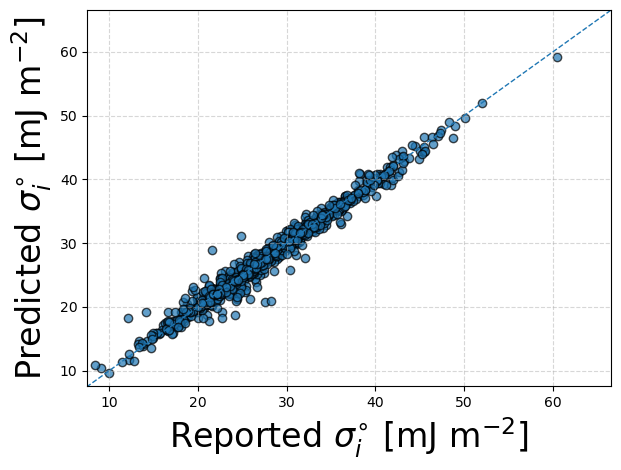

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:36:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [18]:
preds_val = model_gbm.predict(X_val)
mse_val = mean_squared_error(y_val, preds_val)
r2_val = r2_score(y_val, preds_val)
print("MSE : ", mse_val)
print("R^2 : ", r2_val)
plt.scatter(y_val, preds_val, edgecolor='black', alpha=0.7)
plt.plot([0, 100], [0, 100], linestyle='--', linewidth=1)
plt.xlabel(r'Reported $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.ylabel(r'Predicted $\sigma_i^{\circ}$ $[\mathrm{mJ~m^{-2}}]$', fontsize=24)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(0.9*min(y_val), 1.1 * max(y_val))
plt.ylim(0.9*min(y_val), 1.1 * max(y_val))
plot_filename = f"./Figures/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Validation_Plot_Morgan_Optuna.pdf"
#plt.savefig(plot_filename)
plt.show()
plt.close()
model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Morgan.json"
model_gbm.save_model(model_filename)
model_filename = f"./Saved_Models/{datetime.now().strftime('%Y%m%d')}_{model_name.replace(' ', '_')}_Morgan.bin"
model_gbm.save_model(model_filename)